In [1]:
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

Basic Concepts of Signals
============================
When choosing a measurement  system, we need to pay attention to several factors which will greatly influence our ability to perform the measurement adequately. 

More often than not, the factors we will study (i.e. the inputs to the process) will have to be varied in a continuous or discrete manner, and similarly the process output will be monitored over a range of levels. 

The three most basic concepts we will address are:
1. **Waveform** - the shape/form of the signal. 
2. **Amplitude** - the range of the measured or controlled quantity. 
3. **Frequency** - the way the signal varies in time. 


>You were asked to measure the temperature of a water container as a function of the voltage passed through a heating system connected to it. How do you approach this task? what is the range of temperatures you need to measure? at what rate do you expect the temperature to change? How will those affect your choice of a measurement system?


Before discussing properties and analysis of signals, let us differentiate between an **analog** and **digital** signals. 

An **analog** signal is continuous in time. Similarly, the magnitude of the measured signal is continuous within the measure range.

A **digital** signal is a discrete representation in time of the change in the physical variable. The values a digital signal can obtain are also discrete and are determined by the level of *quantization* . 

```{image} ../CoS/ADex.png
:alt: ADex
:width: 500px
:align: center
```
When we sample an analog signal and convert it to a digital signal we represent the signal using a binary representation with a finite number of bits. converting an signal with a range of 5V into a digital signal with $n$, will result in **quantization** into $2^n$ levels. 

```{image} ../CoS/dfqq.png
:alt: dfqq
:width: 500px
:align: center
```
> the above table should have been written while keeping in mind the significant digits but it came out pretty so... **dont do that its a bad habbit!**


In [2]:
### import stuff
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
from IPython import display
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from scipy.fft import fft,fftfreq, ifft
import scipy.signal as sg
fontP = FontProperties()
fontP.set_size('large')
plt.ion()
%matplotlib inline
plt.style.use('seaborn-poster')
rcParams["figure.figsize"] = [12, 8]


In [3]:
# import more stuff just in case
from sympy import oo, DiracDelta, symbols, Function, latex, init_printing
from sympy.plotting import plot as symplt
from sympy.integrals.integrals import Integral
from sympy.integrals.transforms import _fourier_transform as Ftr
from sympy import exp, sin, cos, pi
from sympy import re, im, I, E
from sympy import Heaviside, S


**Static signals** are signals which are (or should be) constant in time. The screen size of your phone for example. 

**Quasi-static signals** are signals whose variation in time is sufficiently slow compared to ....????

**Dynamic signals** are time dependent. the nature of time dependency of the signal will help us to classify it. Signals can be **periodic** with just one frequency, or **complex periodic** suggesting that the signal time dependency is the result of multiple frequencies. Non periodic signals can appear as **steps**; **ramp** or **pulses**. There exist **non deterministic signals** whose characterization is made following their statistics but we will skip that for now. 


### Reminder - properties of periodic signals

A periodic function is characterized by:
- $\color{green}{\text{amplitude}}$
- $\color{blue}{\text{frequency/period}}$
- $\color{orange}{\text{phase}}$

Consider a measurment of an AC signal:

$$ y(t) = \color{red}{D} + \color{green}{A} \sin(2 \pi \color{blue}{f} t + \color{orange}{\phi})  =\color{red}{D} + \color{green}{A} \sin( \color{blue}{\omega} t + \color{orange}{\phi}) $$


In [4]:
%matplotlib inline
#### define our function
def PerSig(A, freq,D,phi, samples):
    t=np.linspace(-np.pi, np.pi, samples)
    omega = 2*np.pi*freq
    y=D + A*np.sin(omega*t+phi)
    y1=D + A*np.sin(omega*t)
    fig,ax = plt.subplots(figsize=(12,8))
    ax.plot(t,y,lw=3,label='signal')
    ax.plot(t,y-D,lw=3,label='just the AC component')
    ax.plot(t,y1,lw=3,label='no phase')
    ax.set_xlabel('time')
    ax.set_ylabel('y(t)')
    ax.legend(bbox_to_anchor=(1.25, 1),loc='upper right', prop=fontP)

interact(PerSig, A = (1,10,1), freq= (0.25, np.pi, 0.2), D=(0,2,1), phi=(0, np.pi, np.pi*0.25), samples=(5,500,20))


interactive(children=(IntSlider(value=5, description='A', max=10, min=1), FloatSlider(value=1.6500000000000001…

<function __main__.PerSig(A, freq, D, phi, samples)>

### Sampling and quantization

When we aim at measuring a continous signal $y(t)$and creating a digital representation of it $y_{samp}(t)$, we have to consider the two processes discussed above:
#### Quantization 
is the result of expressing our continous (in amplitude) signal over a finite number of values. This process will result in roundoff errors.

For example: condiser the function 

$$
y= \sin(2 \pi t)
$$

We know that $y$ will sample any value between $1$ and $-1$ as it is a continous function. 

Now assume that you are sampling it using $[1, 2,4,8,12]$ bits. 

This will results in $[2, 4, 16, 256, 4096]$ allowed levels


In [5]:
def quantY(q,Npoints):
    t0 = np.linspace(-np.pi, np.pi, 1000)
    y0 = np.sin(2*np.pi*t0)
    t = np.linspace(-np.pi, np.pi, Npoints)
    y = np.sin(2*np.pi*t)
    ql = np.linspace(np.min(y),np.max(y),np.power(2,q))
    inds = np.digitize(y, ql)
    yq=np.empty_like(y)
    for n in range(y.size):
        yq[n] = ql[inds[n]-1]
    fig,ax = plt.subplots(figsize=(12,8))
    ax.plot(t0,y0,lw=3,label='continous')
    ax.stem(t,yq,label='')
    ax.plot(t,yq,lw=1,label='quantized')
    ax.set_xlabel('time')
    ax.set_ylabel('y(t)')
    ax.legend(bbox_to_anchor=(1.25, 1),loc='upper right', prop=fontP)

Nps=np.array([5, 20, 50, 100, 250, 5000])
qs=np.array([1,2,4,8,12])
interact(quantY, q = qs, Npoints=Nps)


interactive(children=(Dropdown(description='q', options=(1, 2, 4, 8, 12), value=1), Dropdown(description='Npoi…

<function __main__.quantY(q, Npoints)>

#### Sampling 
referres to the process of obtainning a discrit representation of our signal in time. That is, we measure the value( amplitude) of the signal at prescribed time instances $dt_i$. The sampling points $dt_i$ can be equidistant, arbitrary or dependent on some other measured value (think for example of triggering a higher sampling rate when some condition is met). 

More often than not you will encounter an equidistant sampling. 



By using Dirac's delta we can represent this process using the Dirac comb ${\bot \!\! \bot \!\! \bot}(t) = \sum_{\mu = - \infty}^{\infty} \delta(t - \mu)$ such that :

```{math}
:label: _samp_equi
y_{samp}(t) = y(t) \cdot \frac{1}{T} {\bot \!\! \bot \!\! \bot} \left( \frac{t}{T} \right)
```
the obtained signal $y_{samp}(t)$ is now known only at discrete time values (e.g. $dt_i$)

Before choosing the sampling rate, we will want to make sure that we sampled the **continuos** funtion $y(t)$ such that $y_{samp}(t)$ is a sufficient representation of it. In other words, we will want to make sure that no information (or at least none that we really need) was lost due to this sampling process. 

Without diving into the details of the theory, we will try to gain some intuition about choosing our sampling rate. 


In [6]:
%matplotlib inline
#### define our function
def ContDis(freq,samples):
    phi=0
    A=1.0
    D=0.
    t=np.linspace(-np.pi, np.pi, 1000)
    t1=np.linspace(-np.pi, np.pi, samples)
    omega = 2*np.pi*freq
    y=D + A*np.sin(omega*t+phi)
    y1=D + A*np.sin(omega*t1+phi)
    fig,ax = plt.subplots(figsize=(12,8))
    ax.plot(t,y,lw=3,label='continous')
    ax.stem(t1,y1,label='')
    ax.plot(t1,y1,lw=3,label='discrete')
    ax.set_xlabel('time')
    ax.set_ylabel('y(t)')
    ax.legend(bbox_to_anchor=(1.25, 1),loc='upper right', prop=fontP)
A=1
D=0
interact(ContDis, freq= (0.25, np.pi, 0.25), samples=(3,100,3))


interactive(children=(FloatSlider(value=1.5, description='freq', max=3.141592653589793, min=0.25, step=0.25), …

<function __main__.ContDis(freq, samples)>

```{admonition} Nyquist Shannon sampling theorem


To sample data from a phenomenon whose highest frequency is $f_{phen}$, the sampling frequency $f_{samp}$ is :

$$
f_{samp} \geq 2*f_{phen}
$$ 
    
In other words, assuming we sample our data at $f_{samp} = \frac{1}{dt}$ we are only sensisitve to frequencies below $B =             \frac{f_{samp}}{2}$, and we will not be able to detect properly events whose typical time is less than $2dt$


> For non-equisampled data this is not the only consideration 

Before moving forward, we will first conduct a breif introduction to *Fourier transforms*.
```


Fourier transform is a mathematical tool which allows us to transfer a function (signal) from the time domain to the frequency domain. 

In other words, we can construct the **spectrum** of a function(signal) using :

```{math}
:label: Fourier_1
Y(\omega) = \int_{-\infty}^{\infty} y(t)e^{-i\omega t}dt \ \ ; \ \ y(t) = \frac{1}{2\pi}\int_{-\infty}^{\infty} Y(\omega)e^{i\omega t}d\omega
```
where $\omega$ is defined as $\omega = 2 \pi f $


Lets calculate the Fourier transform of some simple functions, but before we need to remind ourselves about some simple relationships:

$\int\limits_{-\infty}^{\infty} \delta\left(t\right)\, dt = 1$

$\int\limits_{-\infty}^{\infty} f{\left(t \right)} \delta\left(- a + t\right)\, dt = f{\left(a \right)}$

$\int\limits_{-\infty}^{\infty} e^{i t \left(\omega - \omega^{'}\right)}\, dt = 2 \pi \delta (\omega - \omega^{'})$


And now :
##### The Dirack function $\delta(t)$
$$
$$
```{math}
:label: DircaFT
\int_{-\infty}^{\infty} \delta (t) e^{-i \omega t} dt = e^{(-i\omega*0)} = 1
```
##### $exp(i \omega_0 t)$
```{math}
:label: expFT
\int_{-\infty}^{\infty} e^{-i \omega_0 t} e^{-i \omega t} dt \\
= \int_{-\infty}^{\infty} e^{-i (\omega- \omega_0) t} dt  \\
= 2\pi\delta (\omega - \omega_0)
```

##### $\cos(\omega_0 t)$
```{math}
:label: cos
 \int_{-\infty}^{\infty} \cos(\omega_0 t) e^{-i \omega t} dt \\
= \frac{1}{2} \int_{-\infty}^{\infty} [e^{-i (\omega_0) t}+e^{i (\omega_0) t}]   e^{-i \omega t}  dt  \\
= \pi\delta (\omega - \omega_0) +\pi\delta (\omega + \omega_0)
```

##### A square pulse
```{math}
:label: cos
 \int_{-0.5}^{0.5}  e^{-i \omega t} dt \\
=\frac{1}{-i\omega} e^{-i \omega t}|_{-0.5}^{0.5} \\
=\frac{\sin(0.5\omega)}{0.5 \omega}
```


In [7]:
init_printing()
y, t, w ,x=symbols('y, t omega x')
a = symbols('a', positive=True)
f = Function('f')(t)

We will use **sympy** for the next example. 

We will start by defining a function *FT* which gets as an input the function $y(t)$ and returns its Fourier transform $Y(\omega)$.


In [8]:
def FT(y):
    return Ftr(y, t, w,1,-1,'Fourier')


Now we will define a square pulse and visualize its Fourier transform 

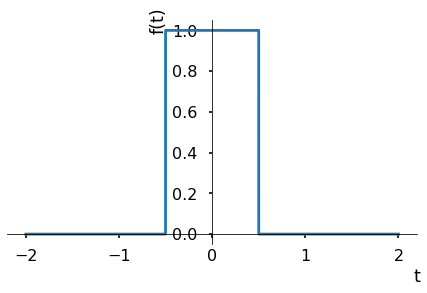

In [9]:
Pulse = Heaviside(t + S.Half) - Heaviside(t - S.Half)
symplt(Pulse,(t,-2,2))

And his Fourier transform is :

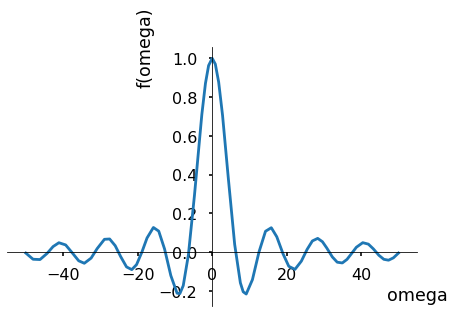

In [10]:
Y=FT(Pulse)
symplt(Y,(w,-50,50))

We already calculated the Fourier transform of a cos function. 

As you saw, the Fourier transform of a single frequency signal returns a delta function around the signal's frequency. 

Let us now introduce the concept of discrete Fourier transforms (DFT). 



#### DFT

```{math}
:label: DFT
Y_{\omega} = \sum_{n=0}^{N-1}{y_n\cdot e^{-i{\omega_n/N}}} 
```
In {eq}`DFT`, $N$ is the number of samples, $\omega$ is the current (angular) frequency , $y_n$ is the discrete representation of $y(t)$ and $Y_{omega}$ is the discrete representaion of $Y(\omega)$.


$Y_{\omega}$ contains the information we seek regarding the amplitude of the different periodic functions in our signal as well as the phase.

The amplitude is calculated using :

$$
A_{\omega} = \frac{|Y_{\omega}|}{N}
$$

An the phase can be calculated from

$$
\phi_{\omega} = \arctan2\left(Im(Y_{\omega}),Re(Y_{\omega})  \right )
$$



```{note}
Here we use :


$$
|z| = \sqrt{Re(z)^2 + Im(z)^2}
$$

Also, $\arctan2$ is the same as $\arctan$ up to $\pm \pi$. it preserves the information as to the sign of $x,y$ 
```

For a real signal (as in not having imagenary component), it is sufficent to plot the positive frequencies alone ( $Y_1 ,...,Y_{(N-1)/2} $).

In such a case the amplitude shown above will be multiplied by two so that it will be in agreement with the signal in the time domain. 


In the examples to follow we will make use of scipy's FFT implementation *(FFT = Fast Fourier Transform)* which is an algorithm used for calculating the DFT. 

We will start by looking at a sum of sine functions such that :

$$
y(t) = 3\sin(5*2\pi t) + 5\sin(7*2 \pi t)
$$


In [11]:
#the time axis:
f=1000 #sampling rate (in Hz)
dt = 1./f
duration = 1
t = np.arange(0,duration,dt)


t =np.arange(0,duration,dt)
#define the signal
sine = lambda b,t: np.sin(b*2*np.pi*t)
y = 3*sine(5,t)+5*sine(7,t)
## FFT
Y = fft(y)
xf=fftfreq(int(f*duration),dt)


Text(0, 0.5, 'Amplitude')

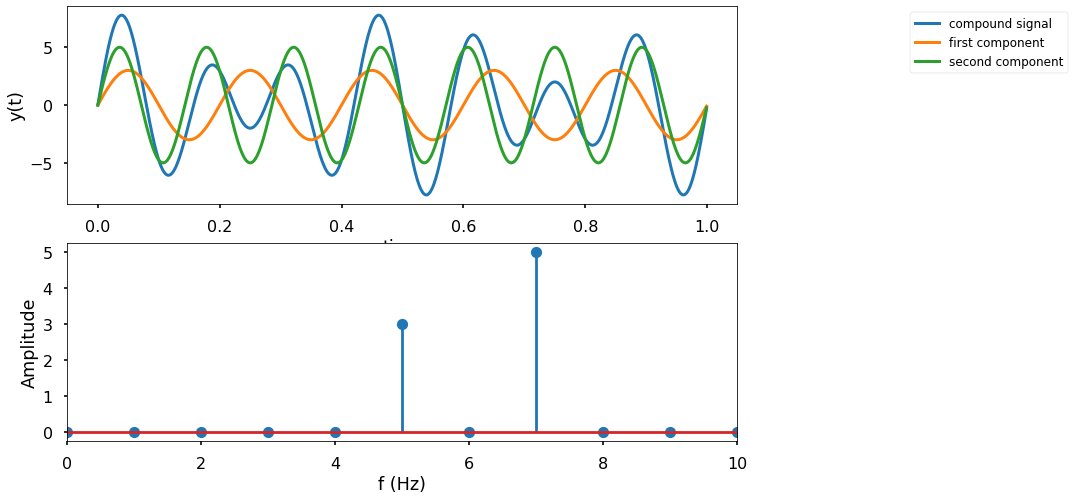

In [12]:

# Plotting
fig,axs = plt.subplots(2,figsize=(12,8))
axs[0].plot(t,y,lw=3,label='compound signal')
axs[0].plot(t,3*sine(5,t),lw=3,label='first component')
axs[0].plot(t,5*sine(7,t),lw=3,label='second component')
axs[0].set_xlabel('time')
axs[0].set_ylabel('y(t)')
axs[0].legend(bbox_to_anchor=(1.25, 1),loc='upper left', prop=fontP)

axs[1].stem(xf,np.abs(Y)/(0.5*len(xf)))
axs[1].set_xlim([0, 10])
axs[1].set_xlabel('f (Hz)')
axs[1].set_ylabel('Amplitude')

We will get back to this but just for demonstration, let see if we can use FFT to filter out unwanted information 

Let us add a $2Hz$ noise on top of our signal 


Text(0, 0.5, 'Amplitude')

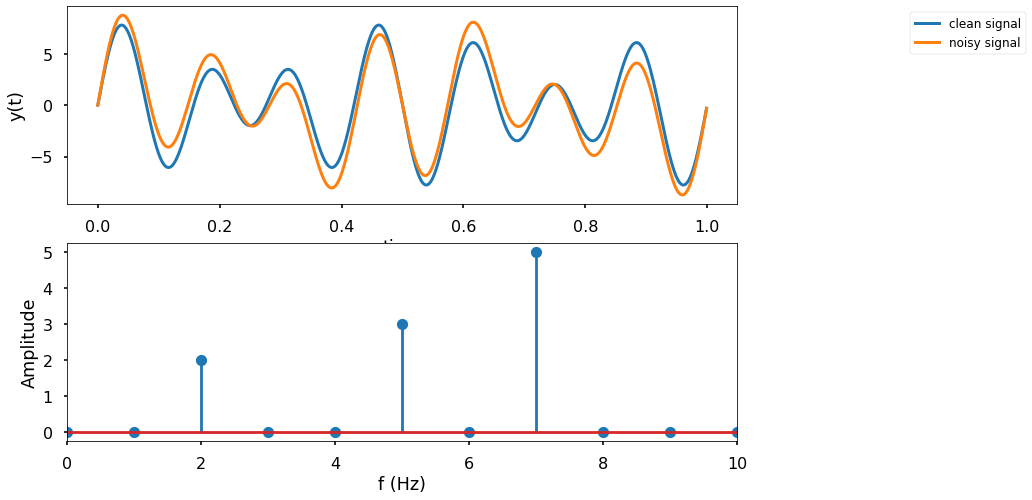

In [13]:
y_noise = y.copy()+ 2*sine(2,t)
Y_noise = fft(y_noise)

fig,axs = plt.subplots(2,figsize=(12,8))
axs[0].plot(t,y,lw=3,label='clean signal')
axs[0].plot(t,y_noise,lw=3,label='noisy signal')
axs[0].set_xlabel('time')
axs[0].set_ylabel('y(t)')
axs[0].legend(bbox_to_anchor=(1.25, 1),loc='upper left', prop=fontP)

axs[1].stem(xf,np.abs(Y_noise)/(0.5*len(xf)))
axs[1].set_xlim([0, 10])
axs[1].set_xlabel('f (Hz)')
axs[1].set_ylabel('Amplitude')


We can define a minimum frequenct that we wish to observe, and remove all components below it :

In [14]:
fmin = 2
cleaned_Y = Y_noise.copy()
cleaned_Y[np.abs(xf)<=fmin]=0
y_filt = ifft(cleaned_Y)

y_noise = y.copy()+ 2*sine(2,t)
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(t,y,'red',lw=4,label='original signal')
ax.plot(t,y_noise,lw=3,label='noisy signal')
ax.plot(t,y_filt,'go',alpha=0.1, label='clean signal')
ax.set_xlabel('time')
ax.set_ylabel('y(t)')
ax.legend(bbox_to_anchor=(1.25, 1),loc='upper left', prop=fontP)

At his point, we atart to understand what is going on, 

I hope, 

If we consider the signal we sample and construct its spectrum, using a discrete representation (Fourier series ) it will end up looking like:

```{math}
:label: spect
Y_{samp}(iw) = \frac{\omega_{samp}}{2\pi} \sum_{n=-\infty}^{\infty}X(i( \omega - n \omega_{samp})) 

```

This means that the spectrum of the sampled signal has a periodicity of $\omega_{samp}$ 

Infact if we consider{eq}'spect' we may notice that the sampled spectrum is a superposition of copies of the original spectrum, shifted by $\omega_{samp}$

```{admonition} To sum it up
We can conclude that as long as the max frequency $\omega_{max}$ is smaller than $\frac{\omega_{samp}}{2}$ the shifted copies of the spectrum will not overlap. 

However, once $\omega_{max}>\frac{\omega_{samp}}{2}$ the shifted replications will overlapp and the sampled spectrum will no longer be reliable
```
